### > install packages

In [2]:
!pip install -Uq opencv-python-headless
!pip install -Uq diffusers==0.21.4

### > setup

In [12]:
# !pip install opencv-python transformers accelerate
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image
import numpy as np
import torch
import gc

import cv2
from PIL import Image

device_count = torch.cuda.device_count()
assert device_count > 0, "No GPU devices detected."

print("Number of available GPU devices:", device_count)

device = torch.device("cuda:0")

Number of available GPU devices: 4


### > download reference image

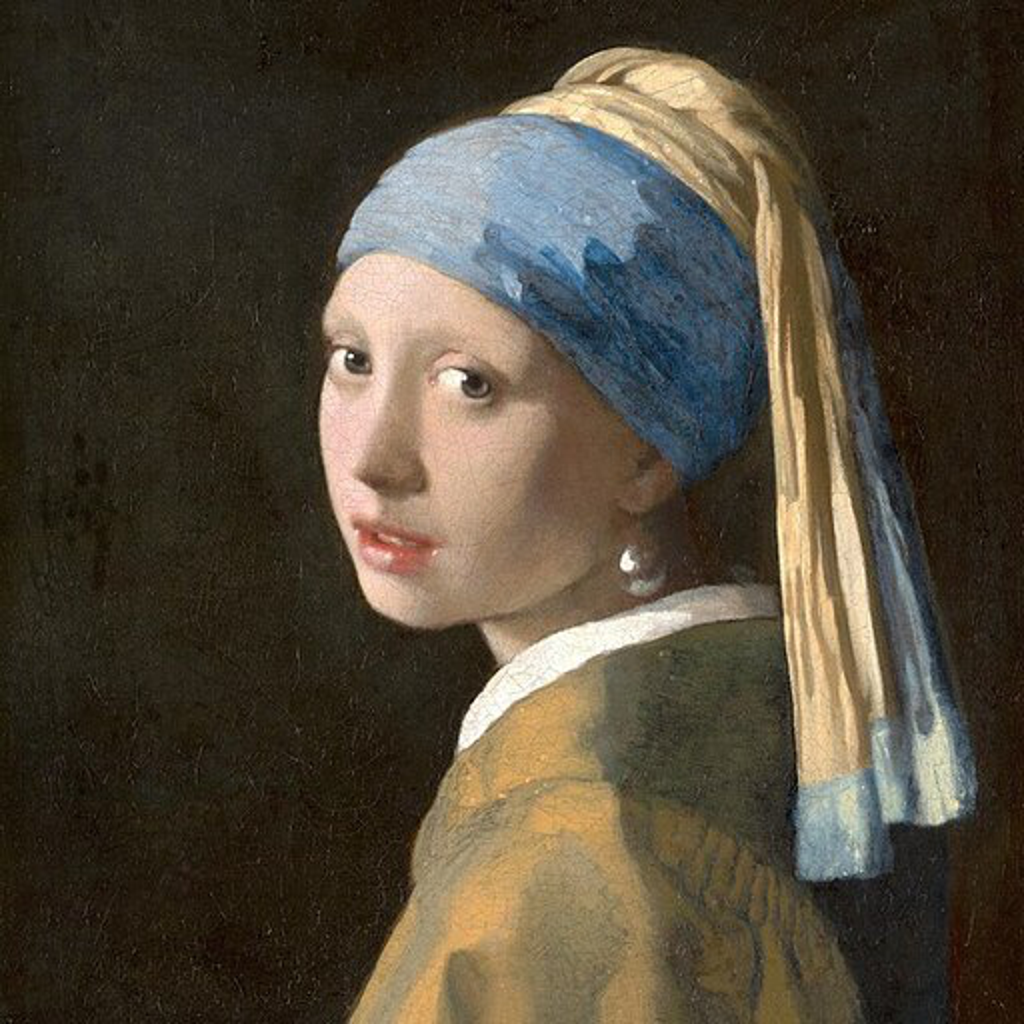

In [21]:
# download an image
# image = load_image(
#     "https://hf.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd_controlnet/hf-logo.png"
# )
# image
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
).resize((1024, 1024))
image

### > import your own image

In [22]:
def center_crop_and_resize(image_path, new_size):
    # Open the image
    image = Image.open(image_path)

    # Calculate the coordinates for center cropping
    width, height = image.size
    left = (width - min(width, height)) // 2
    top = (height - min(width, height)) // 2
    right = (width + min(width, height)) // 2
    bottom = (height + min(width, height)) // 2

    # Perform center cropping
    image = image.crop((left, top, right, bottom))

    # Resize the image to the new size
    image = image.resize(new_size)

    return image

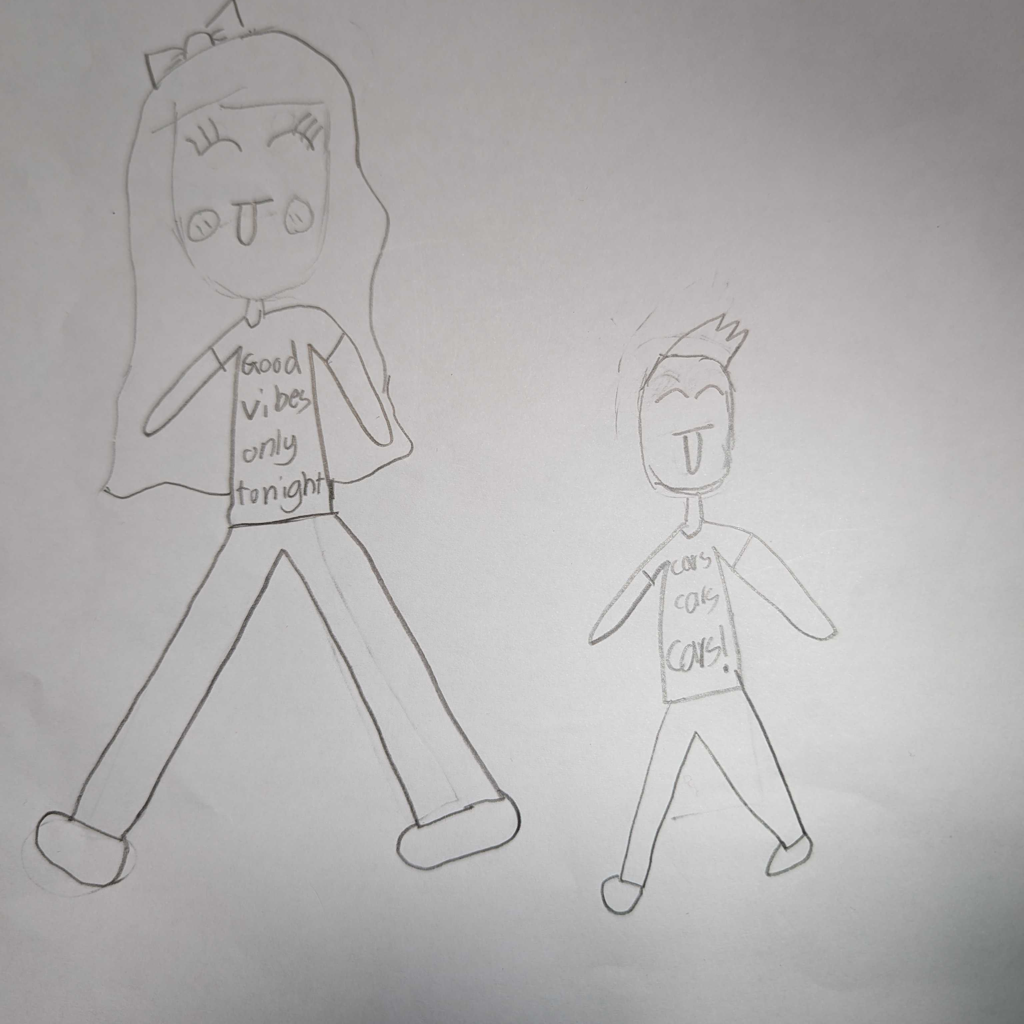

In [26]:
image_path = "sketch.jpg"
new_size = (1024, 1024)
result_image = center_crop_and_resize(image_path, new_size)
result_image

### > load the model

In [23]:
# initialize the models and pipeline
controlnet_conditioning_scale = 0.5  # recommended for good generalization
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0", torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", controlnet=controlnet, vae=vae, torch_dtype=torch.float16
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
# pipe.enable_xformers_memory_efficient_attention()

In [24]:
prompt = "princess Elsa and her snow man Olaf on a frozen lake with snow and moountains"
negative_prompt = "low quality, bad quality, sketches"

### > generate image

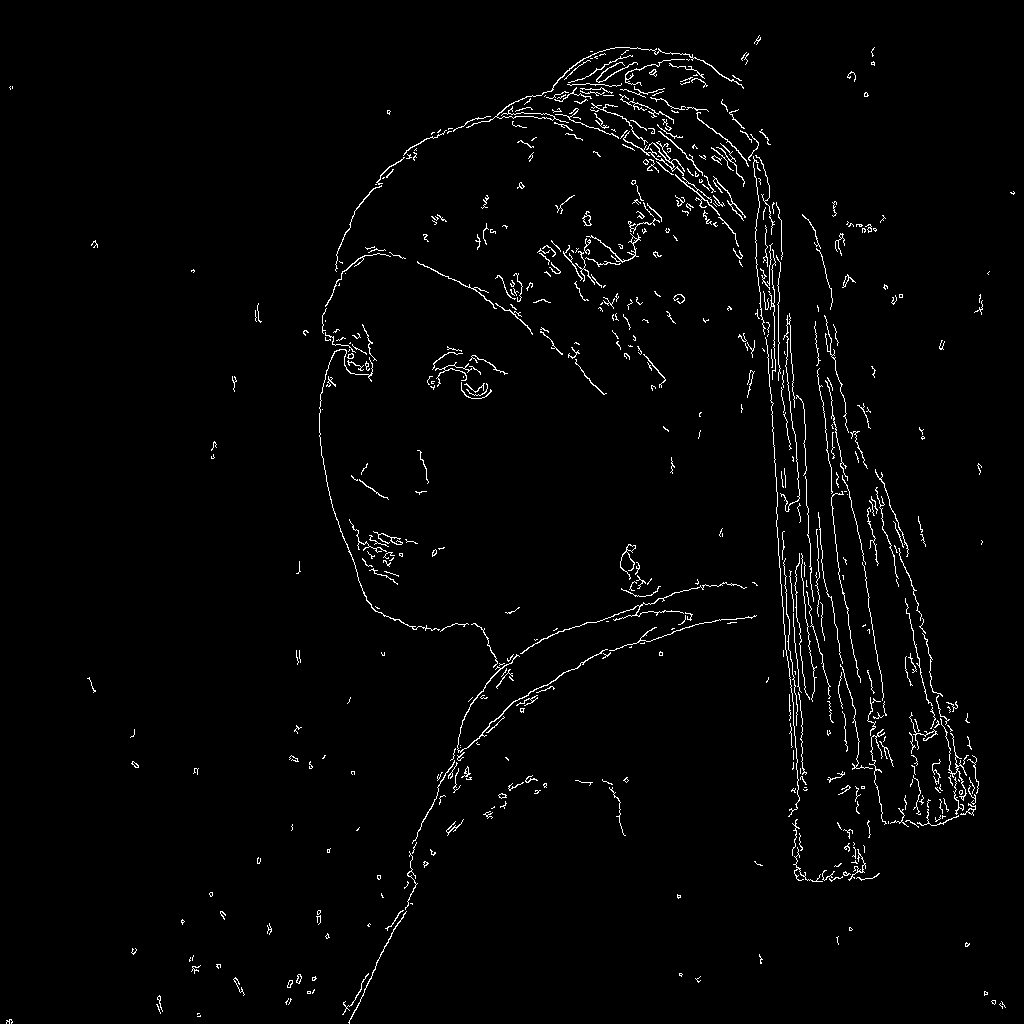

In [25]:
# get canny image
image = np.array(image)
image = cv2.Canny(image, 100, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [ ]:
generator = torch.manual_seed(0)

# generate image
image = pipe(
    "the mona lisa", 
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=controlnet_conditioning_scale, 
    # generator=generator,
    image=canny_image
).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
del pipe
gc.collect()
torch.cuda.empty_cache()

In [1]:
!nvidia-smi

Sun Dec 31 10:24:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         Off  | 00000000:00:1B.0 Off |                    0 |
|  0%   24C    P0    36W / 300W |      2MiB / 22731MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A10G         Off  | 00000000:00:1C.0 Off |                    0 |
|  0%   